# Image Binary Classification
We are given a set of images that are to be classified into either `Type1` or `Type2` based on a set of training images given for each type.

## Studying the Databse
We first load the dataset from the given link onto colab and look at a sample of training images to familiarise ourselves with the type of images we are dealing with.

In [1]:
# wget the zip file onto /tmp

!wget --no-check-certificate \
    https://cloud.mpi-cbg.de/index.php/s/tMCkGvprNsPzeJ7/download \
    -O /tmp/dataset.zip 

--2022-12-15 09:54:09--  https://cloud.mpi-cbg.de/index.php/s/tMCkGvprNsPzeJ7/download
Resolving cloud.mpi-cbg.de (cloud.mpi-cbg.de)... 141.5.10.73
Connecting to cloud.mpi-cbg.de (cloud.mpi-cbg.de)|141.5.10.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip        [<=>                 ]  21.64M  2.72MB/s    in 7.7s    

2022-12-15 09:54:19 (2.81 MB/s) - ‘/tmp/dataset.zip’ saved [22686855]



In [2]:
import os
import zipfile
import shutil

# unzipping
local_zip = '/tmp/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# making necessary directories for train and test data
os.mkdir('/tmp/Problemset/TrainSet')
shutil.move('/tmp/Problemset/Type1', '/tmp/Problemset/TrainSet/Type1')
shutil.move('/tmp/Problemset/Type2', '/tmp/Problemset/TrainSet/Type2')

'/tmp/Problemset/TrainSet/Type2'

We now create two directories `train_type1_dir` and `train_type2_dir` and load the images onto them. Test dataset is not handeled for now.

In [3]:
base_dir = '/tmp/Problemset'
train_dir = os.path.join(base_dir, 'TrainSet')

# Directory with our training type1 pictures
train_type1_dir = os.path.join(train_dir, 'Type1')

# Directory with our training type2 pictures
train_type2_dir = os.path.join(train_dir, 'Type2')

We then look at the number of images in the dataset and the naming of the images to get an idea of the structure. 

We find that there are 1,000 images of each type in the training dataset. Therefore, a total of 2,000 training images are present. We intend to create a 80:20 split for train:validation, giving us 1,600 images for training and 400 for validation.

In [4]:
train_type1_fnames = os.listdir(train_type1_dir)
# print(train_type1_fnames[:10])

train_type2_fnames = os.listdir(train_type2_dir)
train_type2_fnames.sort()
# print(train_type2_fnames[:10])

print('total training Type1 images:', len(os.listdir(train_type1_dir)))
print('total training Type2 images:', len(os.listdir(train_type2_dir)))

total training Type1 images: 1000
total training Type2 images: 1000


We now plot some images from the training dataset to have a look at the nature of the images. We divide the plot in 4:4 subplots and plot some images without their labels (`Type1` or `Type2`).

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

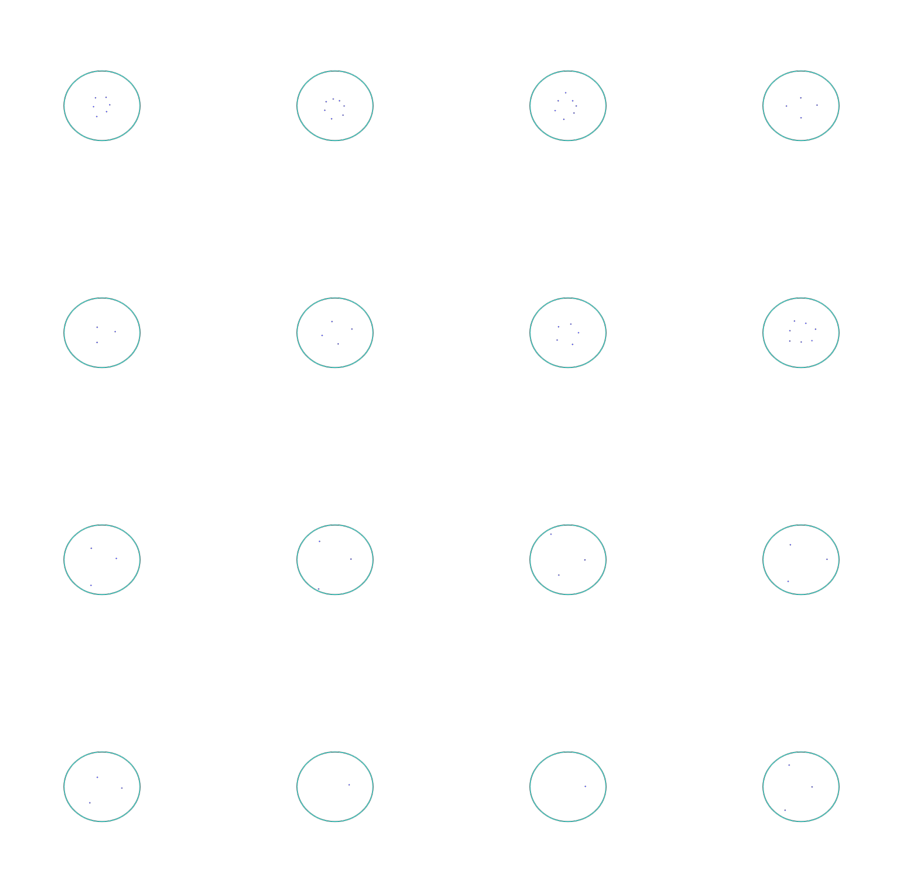

In [6]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_type1_pix = [os.path.join(train_type1_dir, fname) 
                for fname in train_type1_fnames[pic_index-8:pic_index]]
next_type2_pix = [os.path.join(train_type2_dir, fname) 
                for fname in train_type2_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_type1_pix+next_type2_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

As can be seen from the above plot, the images are nothing but circular plots with certain points inside the boundary. This is a particularly simpler dataset with less image statistics involved. 

Therefore, we will write a ConvNet from scratch (individual layers) and look at the accuracy we recieve on the validation set.

## CNN from scratch
We first import the necessary libraries and set the parameters for the given images (dimentions, number of train samples). We also set `batch_size` as 20 for the given set (relatively small number but something that is the divisor of both `nb_train_samples` and `nb_validation_samples`). 

In [7]:
import tensorflow as tf
import numpy as np

In [8]:
batch_size = 20
img_height = 400
img_width = 400
nb_train_samples = 1600
nb_validation_samples = 400

We now generate objects of type `tf.keras.Dataset` using `tf.keras.utils.image_dataset_from_directory` to import the images from the given directories.

Two objects `train_ds` and `validation_ds` are created from the following arguments.

---

**Arguments used**

***validation_split*** - used to specify the split for validation. As mentioned earlier, we are using the standard 80:20 split for traiing our model.

***seed*** - used to shuffle the images while loading them to the dataset object.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 400 files for validation.


We look at the classes imported to the dataset. As expected, the method returns `Type1` and `Type2`.

In [11]:
class_names = train_ds.class_names
print(class_names)

['Type1', 'Type2']


We now plot some of the images from the datatset to illustrate how we iterate through the object. This will be significant will fitting and modeling the dataset.

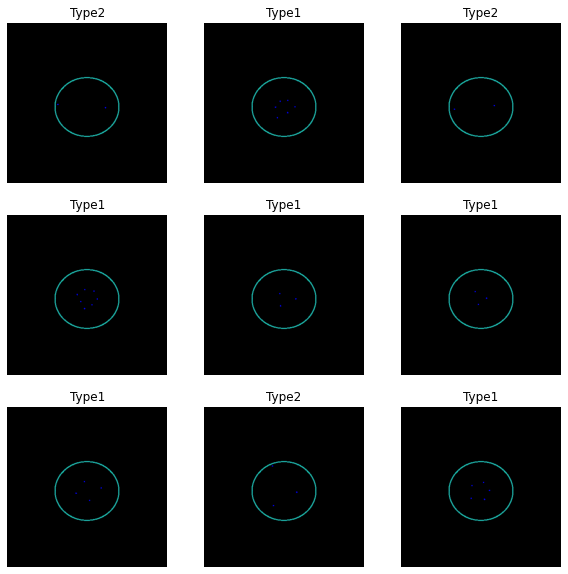

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.



In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

We now code the model that we will be using for training. 

We use `tf.keras.Sequential` to stack the layers used here:


*   **Normalisation** is achieved using `tf.keras.layers.Rescaling(1./255)` which scales down the pixel values from the range [0, 255] to [0, 1]. This makes further computation straightforward as we use activation and modelling that deals with the range of [0, 1].
*   **Convolution layer** is implemented using `tf.keras.layers.Conv2D()` where we will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows which is achieved using `tf.keras.layers.MaxPooling2D()`. Filter size follows the trend of 32-64-128 to extract more and more features after every layer.
*   On top of it we stick two fully-connected layers. The final layer gives the output of the model and therefore it has `num_classes` (2, in our case) units. This is done using `tf.keras.layers.Dense()`

This is a configuration that is widely used and known to work well for image classification for sparse datasets (lesser image statistics to extract). We will stick to lower number of filters as we only have 1,600 training samples and we risk overfitting by increasing the number of filters.

In [14]:
num_classes = 2

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.build((20, 400, 400, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (20, 400, 400, 3)         0         
                                                                 
 conv2d (Conv2D)             (20, 398, 398, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (20, 199, 199, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (20, 197, 197, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (20, 98, 98, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (20, 96, 96, 128)         7

We finally compile our model using `model.compile()`. We are using the `adam` optimizer and `SparseCategoricalCrossentropy()` loss for the compilation. The `adam` optimizer is considered the best for a classification problem like the one we have as it adapts the learning rate eliminating an additional parameter to be tuned. The loss on the other hand is a categorial cross entropy loss which is the standard loss function used for classification.

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

We finally fit the model using 10 `epochs` for the constructed model using the given train and validation datasets and save the generated weights for further evaluation.

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  steps_per_epoch=nb_train_samples // batch_size,
  epochs=10,
  validation_steps=nb_validation_samples // batch_size
)

Epoch 1/10
80/80 [==============================] - 20s 128ms/step - loss: 0.2320 - accuracy: 0.9056 - val_loss: 0.0260 - val_accuracy: 0.9900
Epoch 2/10
80/80 [==============================] - 9s 113ms/step - loss: 0.0146 - accuracy: 0.9944 - val_loss: 0.0837 - val_accuracy: 0.9875
Epoch 3/10
80/80 [==============================] - 9s 114ms/step - loss: 0.0295 - accuracy: 0.9919 - val_loss: 0.0521 - val_accuracy: 0.9900
Epoch 4/10
80/80 [==============================] - 9s 115ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.1377 - val_accuracy: 0.9775
Epoch 5/10
80/80 [==============================] - 9s 115ms/step - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.0848 - val_accuracy: 0.9850
Epoch 6/10
80/80 [==============================] - 9s 116ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0945 - val_accuracy: 0.9900
Epoch 7/10
80/80 [==============================] - 9s 116ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0574 - val_accuracy: 0.9800
Epoch

As seen above, the accuracy becomes stagnant after epoch 8, hence going beyond 10 epochs will just result in overfitting. We now save the weights of the model trained at `/tmp/Problemset/SavedModels/cnn.h5` and plot the accuracy and loss for both train and validation to showcase the change of these outputs with each epoch.

In [ ]:
os.mkdir('/tmp/Problemset/SavedModels')
model.save_weights('/tmp/Problemset/SavedModels/cnn.h5')

Text(0.5, 1.0, 'Training and validation loss')

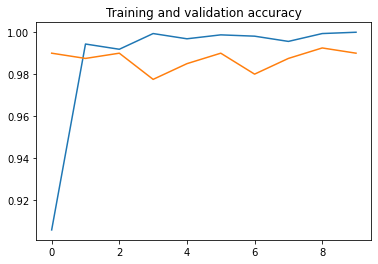

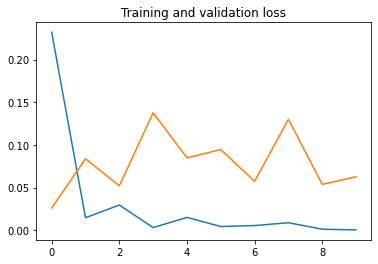

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**Conclusion**
The model written from scratch proves to be really efficient for the given dataset as predicted by looking at the image statistics. We have recieved a test accuracy of `1.00` and validation accuracy of `0.99`. These values indicate that there is no overfitting or underfitting observed. 

## Labelling the Test set

As no true labels are given for the TestSet, we will label the given images after feeding it to our saved model.

In [18]:
for i in range(20):
  image_loc = '/tmp/Problemset/TestSet/Test_{}.png'.format(i)

  img = tf.keras.utils.load_img(image_loc, target_size=(img_height, img_width))

  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array, verbose = 0)
  score = tf.nn.softmax(predictions[0])

  print("{} -> {} with a {:.2f} percent confidence.".format('Test_{}'.format(i),class_names[np.argmax(score)], 100 * np.max(score)))

Test_0 -> Type2 with a 87.83 percent confidence.
Test_1 -> Type1 with a 100.00 percent confidence.
Test_2 -> Type1 with a 100.00 percent confidence.
Test_3 -> Type1 with a 87.58 percent confidence.
Test_4 -> Type1 with a 100.00 percent confidence.
Test_5 -> Type1 with a 100.00 percent confidence.
Test_6 -> Type2 with a 99.78 percent confidence.
Test_7 -> Type2 with a 94.32 percent confidence.
Test_8 -> Type2 with a 100.00 percent confidence.
Test_9 -> Type1 with a 100.00 percent confidence.
Test_10 -> Type1 with a 99.95 percent confidence.
Test_11 -> Type2 with a 100.00 percent confidence.
Test_12 -> Type2 with a 99.65 percent confidence.
Test_13 -> Type1 with a 97.62 percent confidence.
Test_14 -> Type1 with a 100.00 percent confidence.
Test_15 -> Type2 with a 93.74 percent confidence.
Test_16 -> Type2 with a 98.18 percent confidence.
Test_17 -> Type1 with a 99.60 percent confidence.
Test_18 -> Type1 with a 98.51 percent confidence.
Test_19 -> Type1 with a 100.00 percent confidence.
